<a href="https://colab.research.google.com/github/mafaldasalomao/GAN_MINIST_torch/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#classify imagens in little features --- similar pca (reduce dims)
#Vaes
from torchvision import datasets, transforms
import torch
import numpy as np
from torch import nn, optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
torch.__version__

'1.12.1+cu113'

In [2]:
torch.manual_seed(42)

In [1]:
transform = transforms.ToTensor()
train = datasets.MNIST(root = '.', train = True, download = True, 
                       transform = transform)
train_loader = torch.utils.data.DataLoader(train, batch_size = 256, shuffle = True)

NameError: ignored

In [4]:
# construct 
class gerador(nn.Module):
  def __init__(self):
    super().__init__()
    #100->32->64->128->784
    self.dense0 = nn.Linear(100, 32) #receive a vector of 100 numbers random
    self.dense1 = nn.Linear(32, 64)
    self.dense2 = nn.Linear(64, 128)
    self.dense3 = nn.Linear(128, 784)
    self.dropout = nn.Dropout(0.3)

  def forward(self, X):
    X = self.dropout(F.leaky_relu(self.dense0(X), 0.2))# leaky_rely (value * factor)
    X = self.dropout(F.leaky_relu(self.dense1(X), 0.2))
    X = self.dropout(F.leaky_relu(self.dense2(X), 0.2))
    X = torch.tanh(self.dense3(X)) # literature 
    X = X.view(X.shape[0], 28, 28) # convert to image (matriz)
    return X

In [5]:
class discriminador(nn.Module):
  def __init__(self):
    super().__init__()

    self.dense0 = nn.Linear(784, 128)
    self.dense1 = nn.Linear(128, 64)
    self.dense2 = nn.Linear(64, 32)
    self.dense3 = nn.Linear(32, 1)
    self.dropout = nn.Dropout(0.3)
  def forward(self, X):
    X = X.view(X.shape[0], 28*28)
    X = self.dropout(F.leaky_relu(self.dense0(X), 0.2))
    X = self.dropout(F.leaky_relu(self.dense1(X), 0.2))
    X = self.dropout(F.leaky_relu(self.dense2(X), 0.2))
    X = self.dense3(X)
    return X

In [6]:
G = gerador()
D = discriminador()

In [7]:
G_optimizer = optim.Adam(G.parameters(), lr = 0.002)
D_optimizer = optim.Adam(D.parameters(), lr = 0.002)

In [8]:
criterion = nn.BCEWithLogitsLoss() # combine sigmoid with and BCELoss

In [9]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [10]:
G.to(device)


gerador(
  (dense0): Linear(in_features=100, out_features=32, bias=True)
  (dense1): Linear(in_features=32, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=128, bias=True)
  (dense3): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [11]:
D.to(device)

discriminador(
  (dense0): Linear(in_features=784, out_features=128, bias=True)
  (dense1): Linear(in_features=128, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=32, bias=True)
  (dense3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
for epoch in range(100):
    D_running_loss = 0
    G_running_loss = 0
    
    for i, (imagens_reais, _) in enumerate(train_loader):
        batch_size = imagens_reais.size(0)
        imagens_reais = imagens_reais * 2 - 1
        imagens_reais = imagens_reais.to(device)

        # Treinamento do gerador
        G_optimizer.zero_grad()
        ruido = np.random.uniform(low=-1., high=1., size=(batch_size, 100))
        ruido = torch.from_numpy(ruido).float().to(device)
        imagens_falsas = G.forward(ruido)
        outputs_falsas = D.forward(imagens_falsas)
        labels_falsas = torch.ones(batch_size).to(device)
        G_loss = criterion(outputs_falsas.view(*labels_falsas.shape), labels_falsas)
        G_loss.backward()
        G_optimizer.step()

        # Treinamento do discriminador
        D_optimizer.zero_grad()
        outputs_reais = D.forward(imagens_reais)
        labels_reais = (torch.ones(batch_size) * 0.9).to(device)
        D_loss_reais = criterion(outputs_reais.view(*labels_reais.shape), labels_reais)

        ruido = np.random.uniform(-1., 1., (batch_size, 100))
        ruido = torch.from_numpy(ruido).float().to(device)
        imagens_falsas = G.forward(ruido)
        outputs_falsas = D.forward(imagens_falsas)
        labels_falsas = torch.zeros(batch_size).to(device)
        D_loss_falsas = criterion(outputs_falsas.view(*labels_falsas.shape), labels_falsas)

        D_loss = D_loss_reais + D_loss_falsas
        D_loss.backward()
        D_optimizer.step()

        D_running_loss += D_loss.item()
        G_running_loss += G_loss.item()

        # Imprimindo os dados referentes a esse batch   
        print('\rÉpoca {:03d} - Loop {:3d} de {:3d}: custo discriminador {:03.5f} - custo gerador {:03.5f}'.format(epoch + 1, i + 1, len(train_loader), D_loss.item(), G_loss.item()), end = '\r')
  
    # Imprimindo os dados referentes a essa época
    D_running_loss /= len(train_loader)
    G_running_loss /= len(train_loader)
    print('ÉPOCA {:03d} finalizada: custo discriminador {:03.6f} - custo gerador {:03.6f}      '.format(epoch + 1, D_running_loss, G_running_loss))

    fig, ax = plt.subplots(1, 5, figsize=(10,5))
    for i in range(5):
      ax[i].imshow(imagens_falsas.cpu().detach().numpy()[i].reshape(28, 28), cmap='gray')
      ax[i].xaxis.set_visible(False)
      ax[i].yaxis.set_visible(False)
    plt.show()


In [14]:
ruido = np.random.uniform(-1., 1., (20, 100))


ruido = torch.from_numpy(ruido).float().to(device)

In [15]:
G.eval()
previsao  = G.forward(ruido)



In [16]:
previsao = previsao.cpu().detach().numpy()

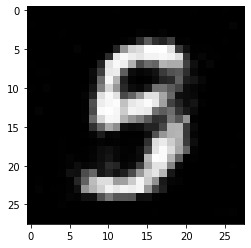

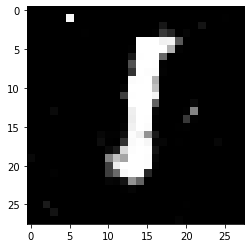

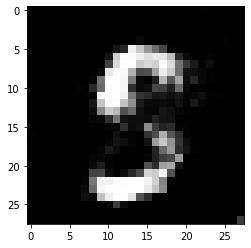

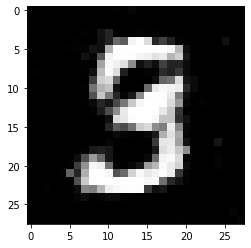

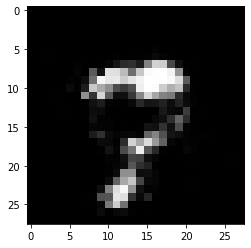

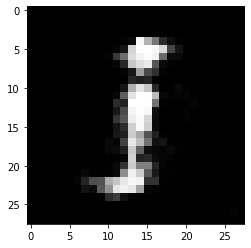

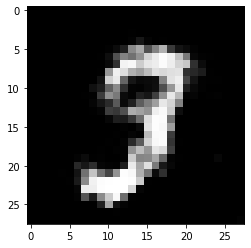

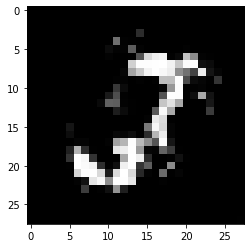

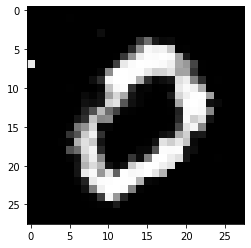

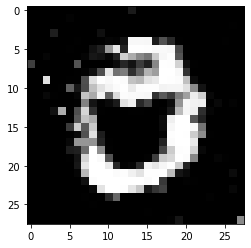

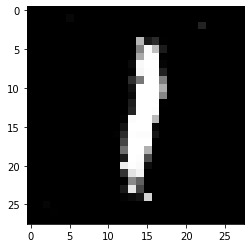

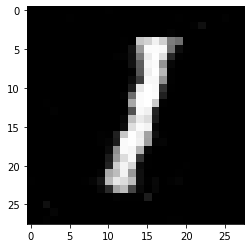

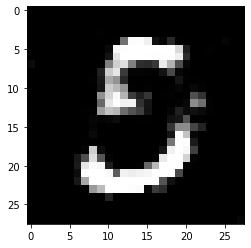

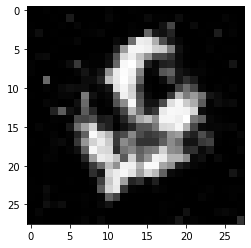

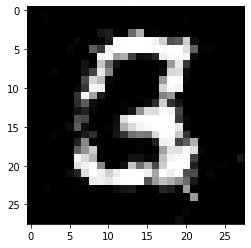

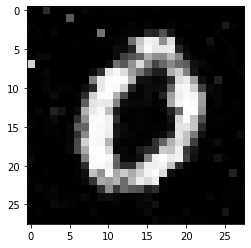

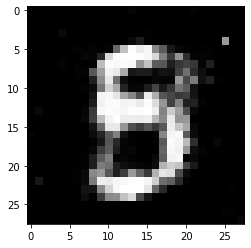

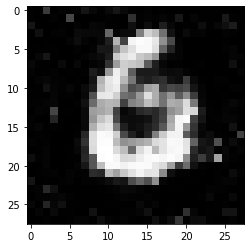

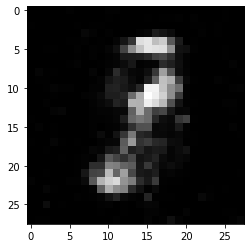

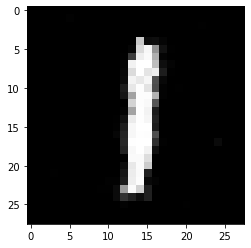

In [17]:
for i in range(previsao.shape[0]):
  plt.imshow(previsao[i, :].squeeze(), cmap='gray')
  plt.show()